## Introduction

## Business Understanding

## Objectives

### 1. Main Objective

### 2. Specific Objectives

## Data Understanding

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#### Loading the data

In [2]:
# Load the provided training_set_values, test_set_values and training_set_labels datasets
train = pd.read_csv('../Data/training_set_values.csv')
test = pd.read_csv('../Data/test_set_values.csv')
train_labels = pd.read_csv('../Data/training_set_labels.csv')

In [3]:
# Merge train set labels and train set values

train_merge = pd.merge(train, train_labels, on = 'id')

#### Checking data properties

In [4]:
# Training data properties
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
# testing data 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [6]:
# Total number of functional and un-functional wells

train_merge.status_group.value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

## Data Preparation

### Data Cleaning

#### a. Checking for duplicates

In [7]:
# Check for duplicate values
print(train_merge.duplicated(subset = ['id']).value_counts())
print(test.duplicated(subset = ['id']).value_counts())

False    59400
Name: count, dtype: int64
False    14850
Name: count, dtype: int64


#### b. Removing unnecessary columns

Several columns are first removed for various reasons.

- **id** is not a meaningful predictor
- **amount_tsh** is mostly blank
- **recorded_by** has only one unique value and therefore does not provide any variability
- **num_private** mostly has zeros as entries
- **scheme_name** is has alot of missing values (50%) and will therefore be dropped
- The following columns have similar information, which will lead to multicollinearity. So we will keep one of each:
    - **region, region_code**
    - **extraction_type_group, extraction_type_group, extraction_type_class**
    - **payment, payment_type**
    - **quantity, quantity_group**
    - **source, source_type**
    - **waterpoint_type, waterpoint_type_group**
    - **water_quality, quality_group**
    

In [8]:
columns_to_remove = ['id','amount_tsh', 'recorded_by', 'num_private', 'region', 'quantity', 'quality_group', 'source_type', 'payment', 
          'waterpoint_type_group', 'scheme_name', 'extraction_type_group']

train_merge = train_merge.drop(columns_to_remove, axis =1)
test = test.drop(columns_to_remove, axis =1)

In [9]:
train_merge.columns

Index(['date_recorded', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'basin', 'subvillage', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type', 'status_group'],
      dtype='object')

#### c. Changing the datatype

'date_recorded' has an **object** datatype, we will change this to **datetime** datatype

In [10]:
train_merge['date_recorded'] = pd.to_datetime(train_merge['date_recorded'])
test['date_recorded'] = pd.to_datetime(test['date_recorded'])

#### d. Imputing Missing Construction Year Values with the median

In [11]:
median_year = train_merge['construction_year'].median()
train_merge['construction_year'] = train_merge['construction_year'].replace(0, median_year)
test['construction_year'] = test['construction_year'].replace(0, median_year)

#### e. Creating a new column 'well_age'

In [12]:
train_merge['well_age'] = train_merge['date_recorded'].dt.year - train_merge['construction_year']
test['well_age'] = test['date_recorded'].dt.year - test['construction_year']

#### f. Filling missing values for specified categorical columns

In [13]:
# Check missing values

print(train_merge.isnull().sum())
print(test.isnull().sum())

date_recorded               0
funder                   3637
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    2
basin                       0
subvillage                371
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
scheme_management        3878
permit                   3056
construction_year           0
extraction_type             0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source                      0
source_class                0
waterpoint_type             0
status_group                0
well_age                    0
dtype: int64
date_recorded              0
funder                   870
gps_height                 0


In [14]:
# Fill the missing values
fill = {
    'funder': 'Unknown',
    'installer': 'Unknown',
    'scheme_management': 'Unknown',
    'wpt_name': 'Unknown',
    'subvillage': 'Unknown',
    'permit': 'False',
    'public_meeting': 'False'
}

train_merge.fillna(value = fill, inplace=True)
test.fillna(value = fill, inplace = True)

#### g. Checking for placeholder values

In [15]:
# Checking for placeholder values
for col in train_merge.columns:
    print(col, '\n', train_merge[col].value_counts(normalize=True).head(), '\n\n')

date_recorded 
 date_recorded
2011-03-15    0.009630
2011-03-17    0.009394
2013-02-03    0.009192
2011-03-14    0.008754
2011-03-16    0.008636
Name: proportion, dtype: float64 


funder 
 funder
Government Of Tanzania    0.152929
Unknown                   0.061296
Danida                    0.052424
Hesawa                    0.037071
Rwssp                     0.023131
Name: proportion, dtype: float64 


gps_height 
 gps_height
 0       0.344074
-15      0.001010
-16      0.000926
-13      0.000926
 1290    0.000875
Name: proportion, dtype: float64 


installer 
 installer
DWE           0.292963
Unknown       0.061582
Government    0.030724
RWE           0.020303
Commu         0.017845
Name: proportion, dtype: float64 


longitude 
 longitude
0.000000     0.030505
37.375717    0.000034
38.340501    0.000034
39.086183    0.000034
33.005032    0.000034
Name: proportion, dtype: float64 


latitude 
 latitude
-2.000000e-08    0.030505
-6.985842e+00    0.000034
-6.980220e+00    0.000034
-2.

#### h. Checking for outliers

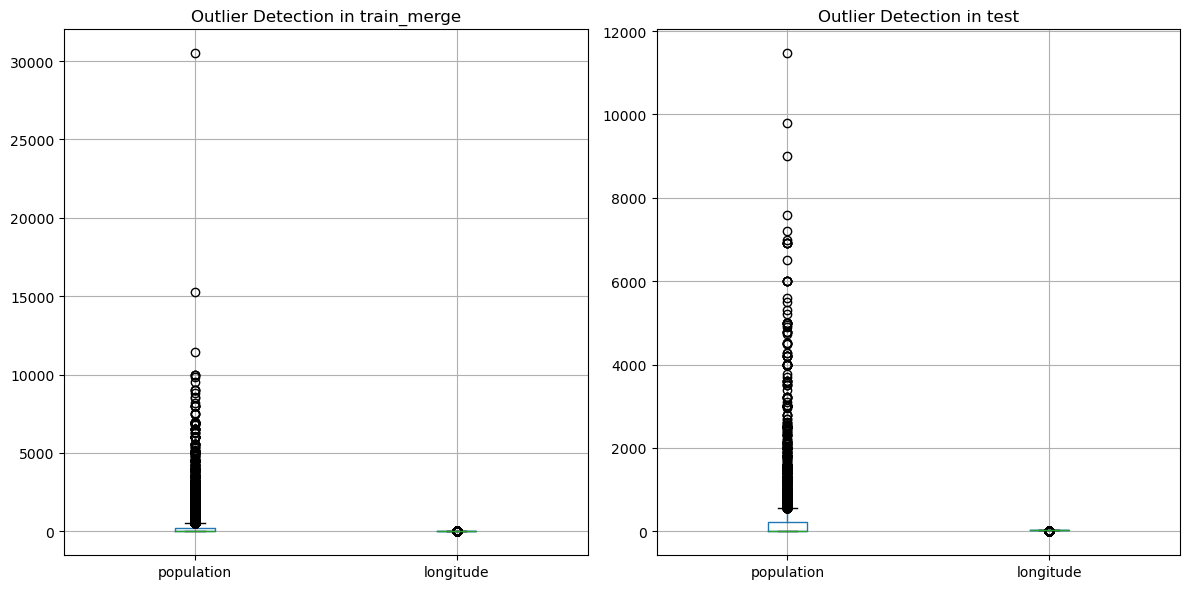

In [16]:
# Plot box plots to visualize outliers in the datasets
dataframes = [('train_merge', train_merge), ('test', test)]

# Plot side-by-side boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for ax, (name, df) in zip(axes, dataframes):
    df[['population', 'longitude']].boxplot(ax=ax)
    ax.set_title(f'Outlier Detection in {name}')

plt.tight_layout()
plt.show()

In [17]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = test[['population', 'longitude']].quantile(0.25)
Q3 = test[['population', 'longitude']].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers from test data
test = test[~((test[['population', 'longitude']] < (Q1 - 1.5 * IQR)) | 
                                           (test[['population', 'longitude']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [18]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_merge[['population', 'longitude']].quantile(0.25)
Q3 = train_merge[['population', 'longitude']].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers from training data
train_merge = train_merge[~((train_merge[['population', 'longitude']] < (Q1 - 1.5 * IQR)) | 
                                           (train_merge[['population', 'longitude']] > (Q3 + 1.5 * IQR))).any(axis=1)]

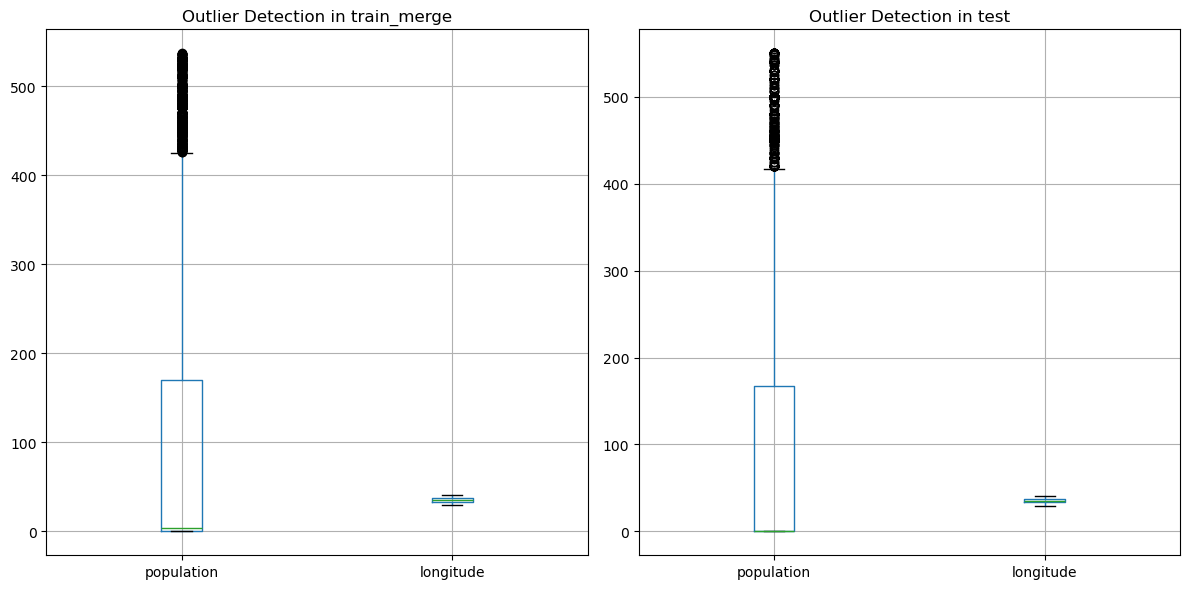

In [19]:
# Plot box plots to visualize outliers in the datasets
dataframes = [('train_merge', train_merge), ('test', test)]

# Plot side-by-side boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for ax, (name, df) in zip(axes, dataframes):
    df[['population', 'longitude']].boxplot(ax=ax)
    ax.set_title(f'Outlier Detection in {name}')

plt.tight_layout()
plt.show()

#### i. Convert the target variable from ternary to binary

Since the goal of this project is to predict the operating condition of a waterpoint for each record in the dataset, we
will use the **status_group** column as our target variable, since it has the following categories:

- Functional
- Non-functional
- Functional Needs Repair

However, the project requires that this is a binary classification problem. For this reason, we will merge _'functional needs repair'_ with _'non-functional'_. If a waterpoint that needs repair is considered not fully functional, merging it with 'non-functional' aligns better with this project's objectives. We will therefore have two classes:

- **Class 1**: 'Functional'
- **Class 2**: 'Non-Functional' + 'functional needs repair'

This way, we will focus on predicting whether a waterpoint is fully functional or requires intervention (either repair or replacement).

In [20]:
# Merge 'functional needs repair' and 'non-functional' into one class
train_merge['status_group'] = train_merge['status_group'].replace({'functional needs repair': 'non functional'})

## Exploratory Data Analysis

### 1. Univariate Analysis

#### a. Distribution of target variable 'status_group'

C:\Users\HP\AppData\Local\Temp\ipykernel_10544\1004615947.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status_group', data=train_merge, palette='Set2')


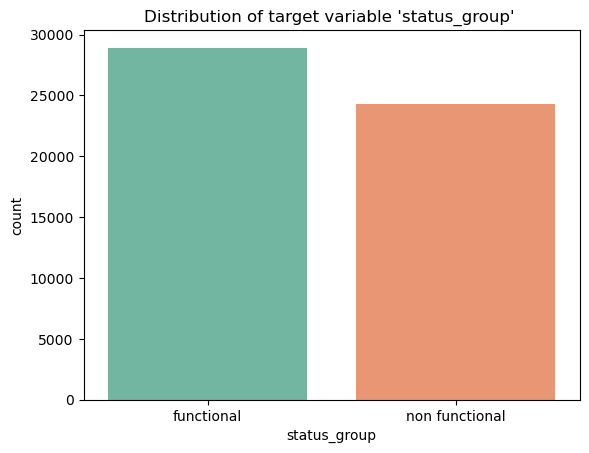

In [25]:
# Create the plot
#plt.figure(figsize=(10, 6))
sns.countplot(x='status_group', data=train_merge, palette='Set2') 

# Add the title
plt.title("Distribution of target variable 'status_group' ")

# Show the plot
plt.show()

In [26]:
train_merge['status_group'].value_counts(normalize = True)

status_group
functional        0.543445
non functional    0.456555
Name: proportion, dtype: float64

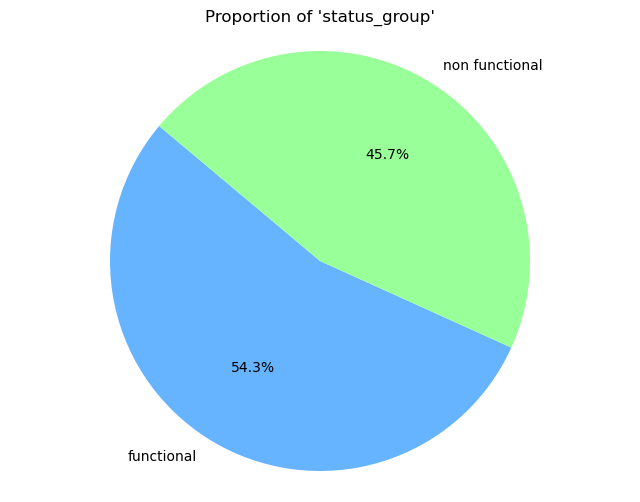

In [28]:
# Visualize normalized proportions

proportions = train_merge['status_group'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', colors=['#66b3ff', '#99ff99'], startangle=140)
plt.title("Proportion of 'status_group'")
plt.axis('equal') 
plt.show()

#### b. Distribution of 'well_age'

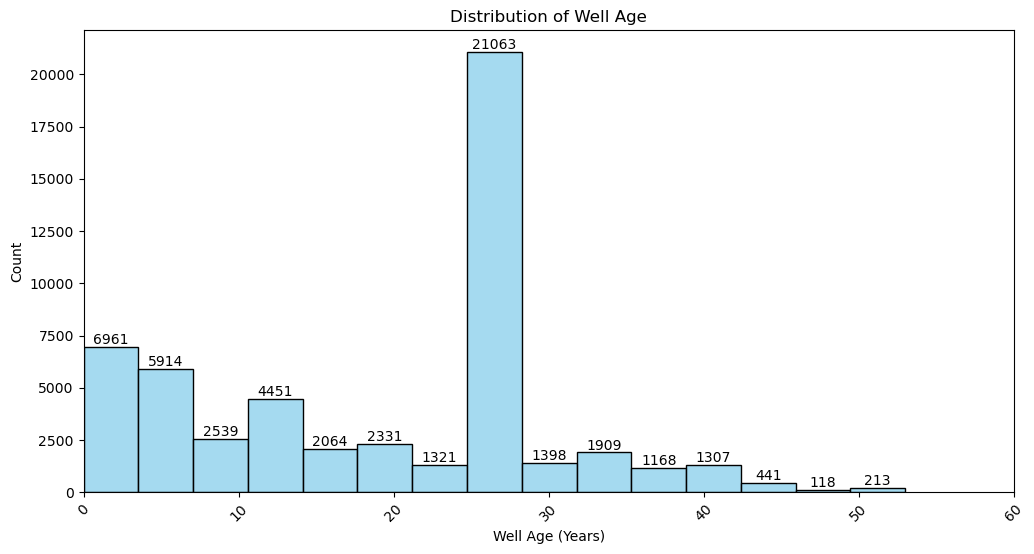

In [34]:
# Filter out negative values
filtered_well_age = train_merge[train_merge['well_age'] >= 0]['well_age']

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.histplot(filtered_well_age, bins=15, color='skyblue') 

# Add the title and labels
plt.title('Distribution of Well Age')
plt.xlabel('Well Age (Years)')
plt.ylabel('Count')

# Add counts on top of each bar
for patch in ax.patches:
    height = patch.get_height()
    if height > 0: 
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2., height),
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')

# Limit x-axis range to improve clarity and readability
plt.xlim(0, 60)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()


#### c. Frequency Distribution: 'installer', 'scheme_management', 'extraction_type', 'waterpoint_type'

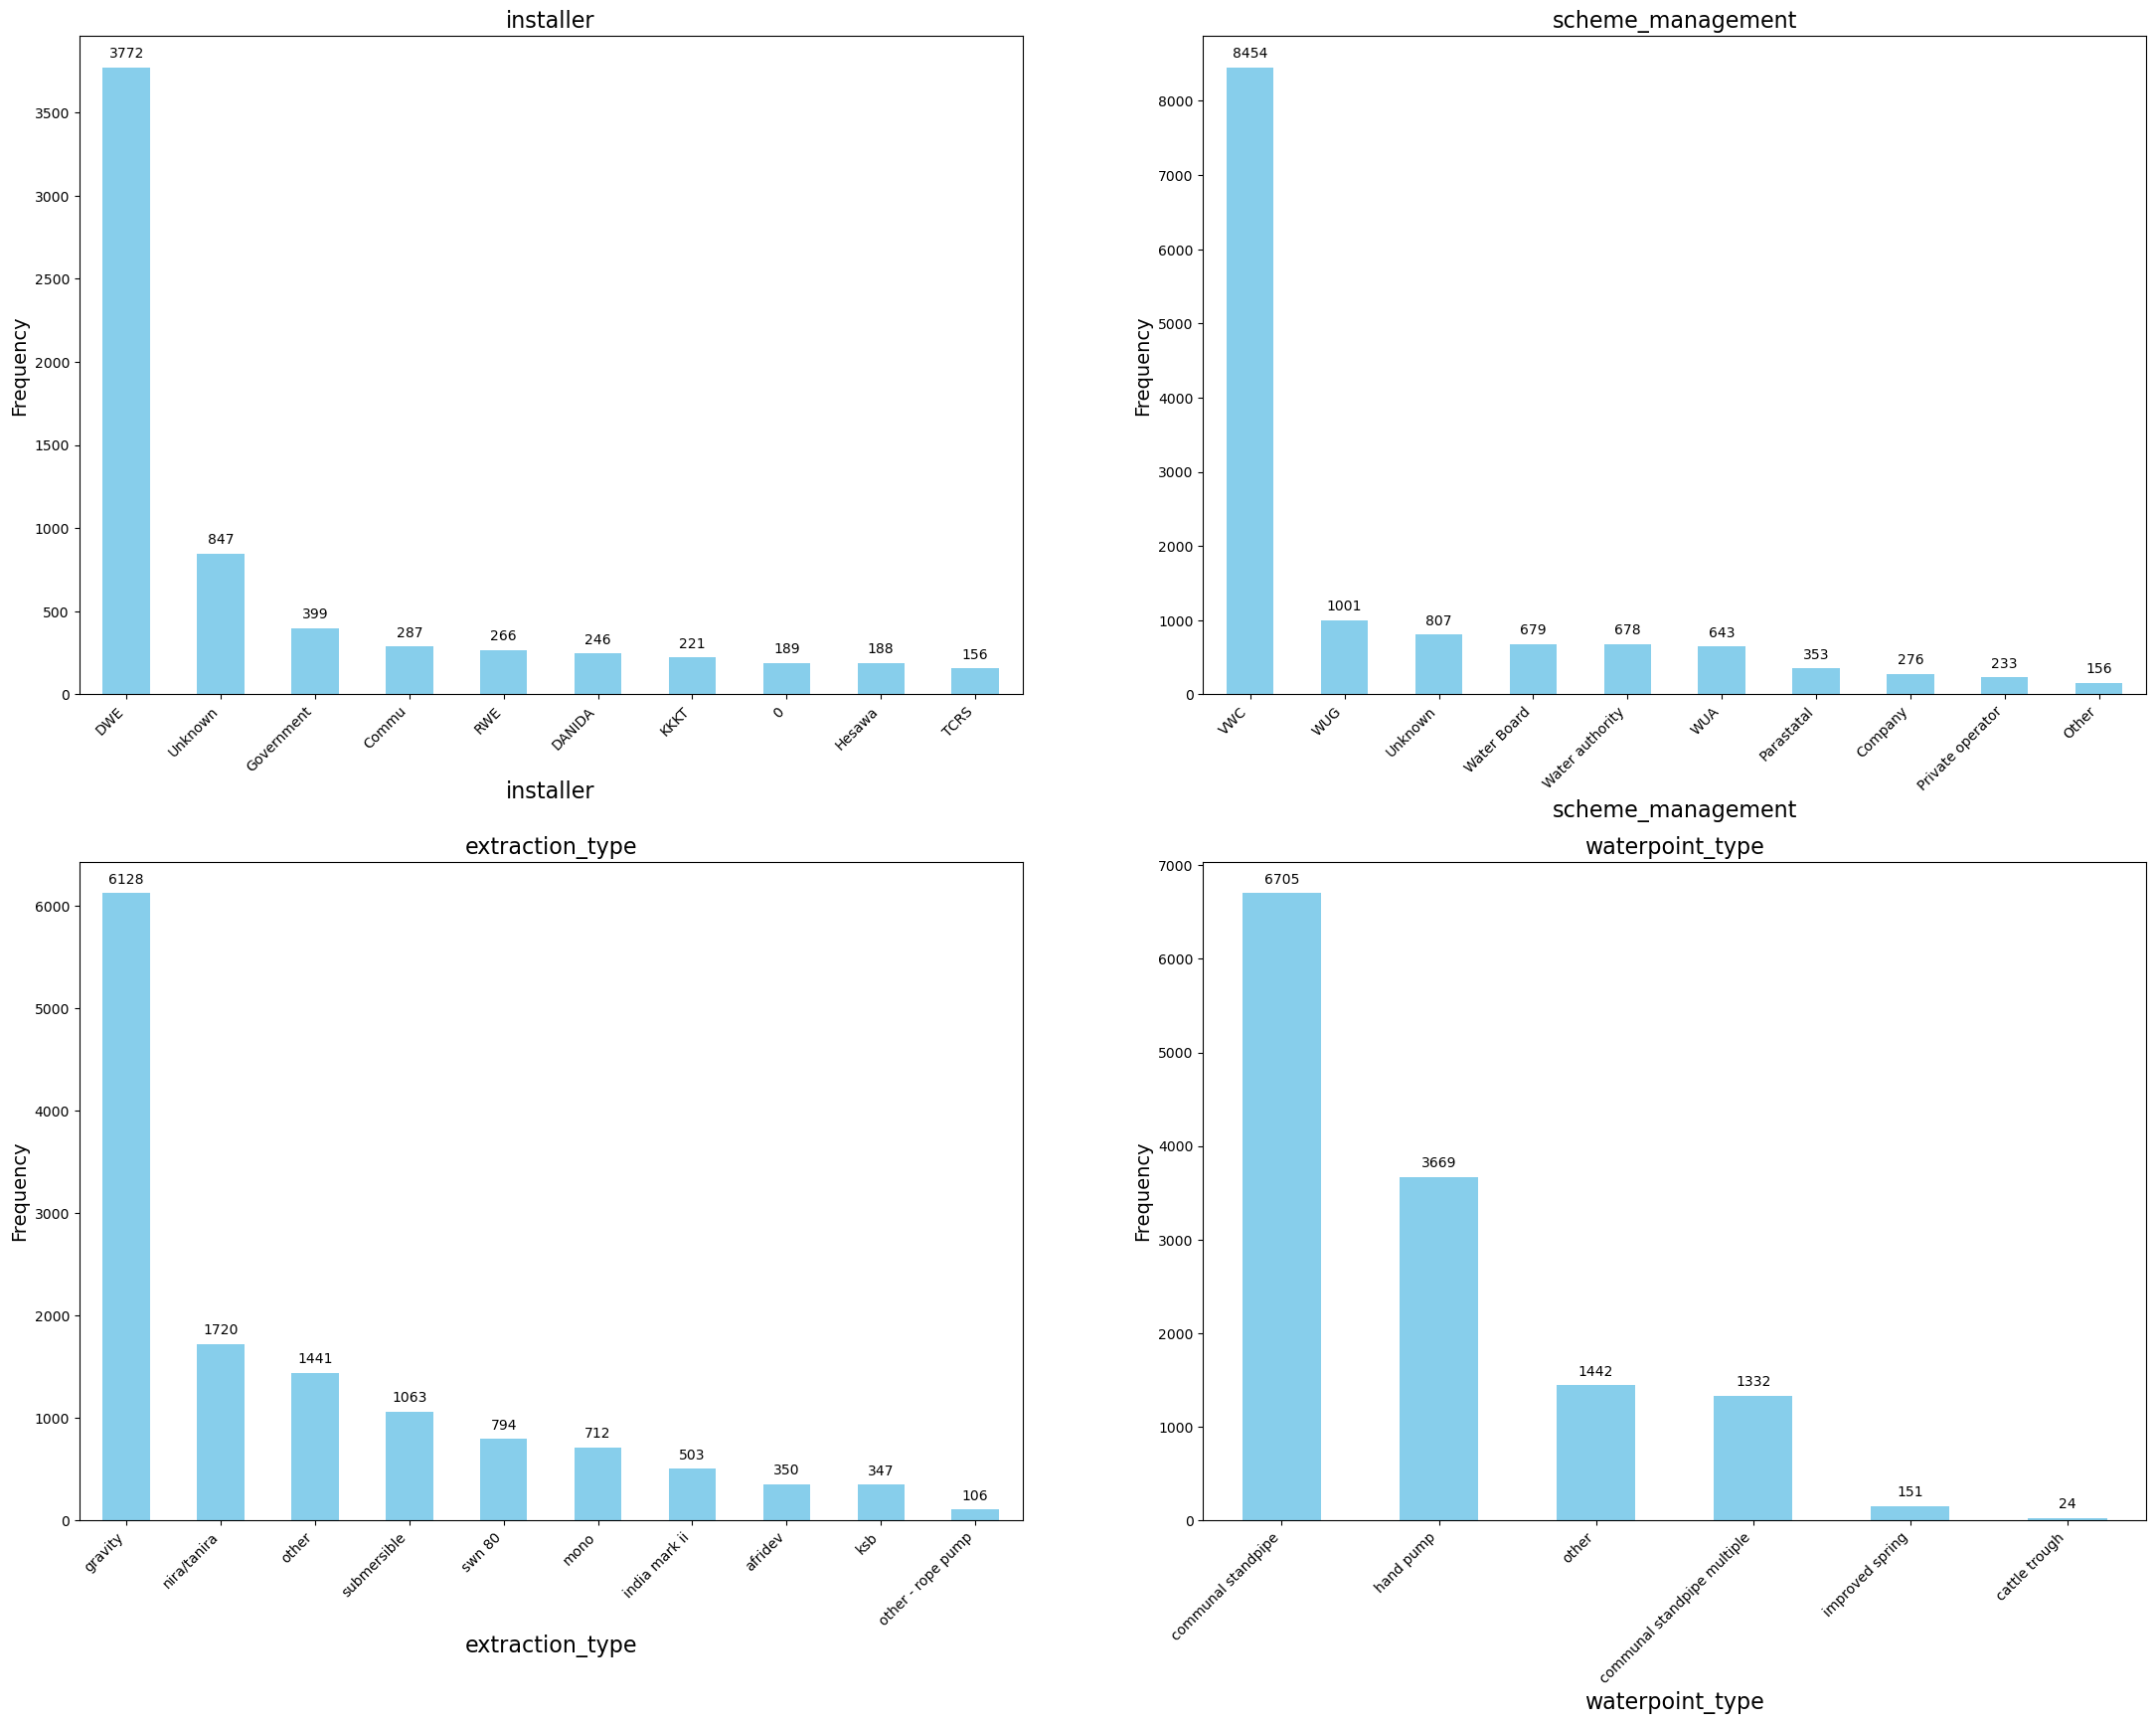

In [46]:
# List of categorical columns to analyze
categorical_columns = ['installer', 'scheme_management', 
    'extraction_type', 'waterpoint_type'
]

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
fig.tight_layout(pad=10.0) 

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each categorical column
for i, column in enumerate(categorical_columns):
    # Calculate value counts and plot
    df[column].value_counts().head(10).plot(kind='bar', ax=axes[i], color='skyblue')
    
    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Add data labels on top of the bars
    for p in axes[i].patches:
        axes[i].annotate(
            int(p.get_height()), 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
            textcoords='offset points'
        )

    
    # Set titles and labels
    axes[i].set_title(f'{column}', fontsize=16)
    axes[i].set_ylabel('Frequency', fontsize=14)
    axes[i].set_xlabel(column, fontsize=16)

# Remove any empty subplots (if the number of categories is not a multiple of num_columns)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show plot
plt.show()


### 2. Bivariate Analysis

#### Target Vs Categorical Predictors

#### a. Distribution of 'status_group' against 'installer'

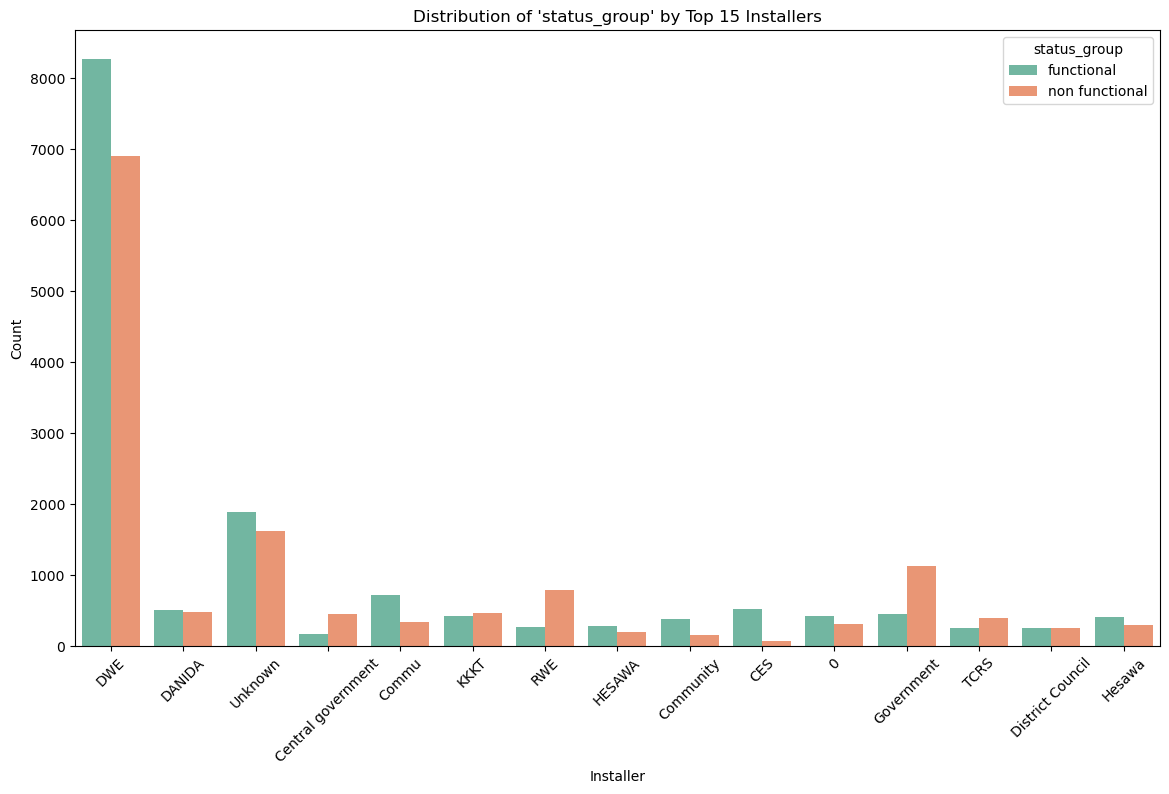

In [49]:
# Get the top 15 most frequent installers
top_installers = train_merge['installer'].value_counts().nlargest(15).index

# Filter the dataframe to include only the top 15 installers
filtered_data = train_merge[train_merge['installer'].isin(top_installers)]

# Create a count plot with the filtered data
plt.figure(figsize=(14, 8))
ax = sns.countplot(x='installer', hue='status_group', data=filtered_data, palette='Set2')

# Add title and labels
plt.title("Distribution of 'status_group' by Top 15 Installers")
plt.xlabel('Installer')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


#### b. Distribution of 'status_group' against 'extraction_type'

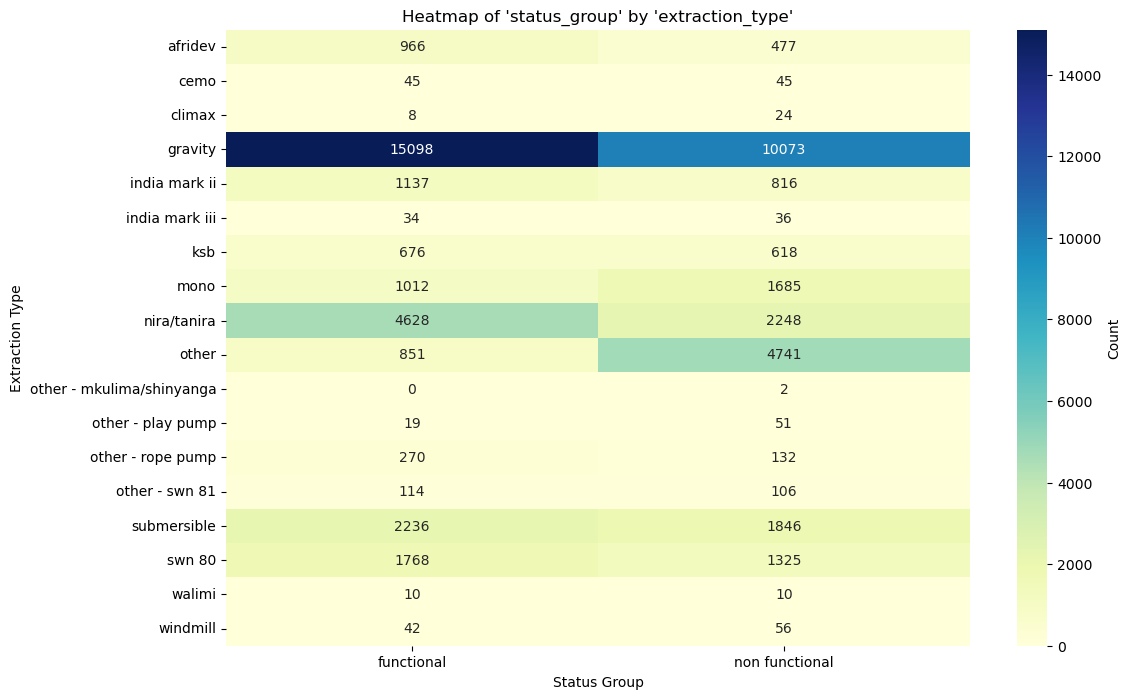

In [50]:
# Create a crosstab for 'extraction_type' and 'status_group'
cross_tab = pd.crosstab(train_merge['extraction_type'], train_merge['status_group'])

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'})

# Add title and labels
plt.title("Heatmap of 'status_group' by 'extraction_type'")
plt.xlabel('Status Group')
plt.ylabel('Extraction Type')

# Show the plot
plt.show()


#### Target Vs Numerical Predictors

#### c. Distribution of 'status_group' against 'well_age'

C:\Users\HP\AppData\Local\Temp\ipykernel_10544\1636575745.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status_group', y='well_age', data=train_merge, palette='Set3')


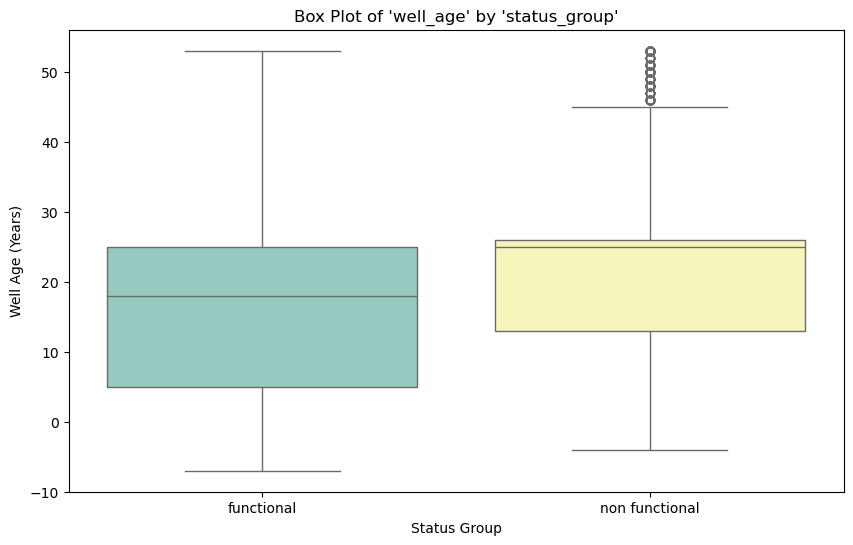

In [51]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='status_group', y='well_age', data=train_merge, palette='Set3')

# Add title and labels
plt.title("Box Plot of 'well_age' by 'status_group'")
plt.xlabel('Status Group')
plt.ylabel('Well Age (Years)')

# Show the plot
plt.show()


#### d. Distribution of 'status_group' against 'population'

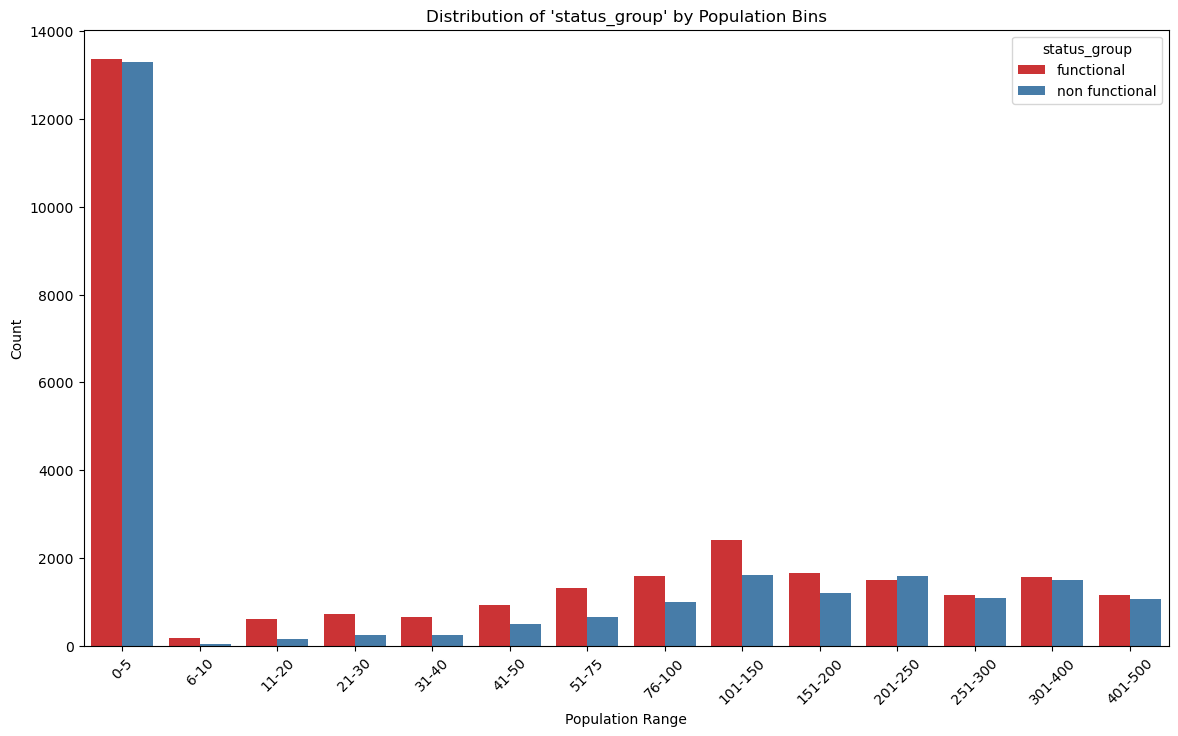

In [54]:
# Define bins for the 'population'
bins = [0, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 400, 500]
bin_labels = ['0-5', '6-10', '11-20', '21-30', '31-40', '41-50', '51-75', '76-100', '101-150', '151-200', '201-250', '251-300', '301-400', '401-500']

# Create a new column 'population_bins' with binned population data
train_merge['population_bins'] = pd.cut(train_merge['population'], bins=bins, labels=bin_labels, include_lowest=True)

# Create a count plot using the binned 'population' data
plt.figure(figsize=(14, 8))
sns.countplot(x='population_bins', hue='status_group', data=train_merge, palette='Set1')

# Add title and labels
plt.title("Distribution of 'status_group' by Population Bins")
plt.xlabel('Population Range')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


### 3. Multivariate Analysis

#### Visualizing Geospatial Distribution of Waterpoints

This analysis aims at exploring how geographic location, combined with other variables,affects the operating condition of waterpoints

In [22]:
! pip install geopandas

<Figure size 1000x800 with 0 Axes>

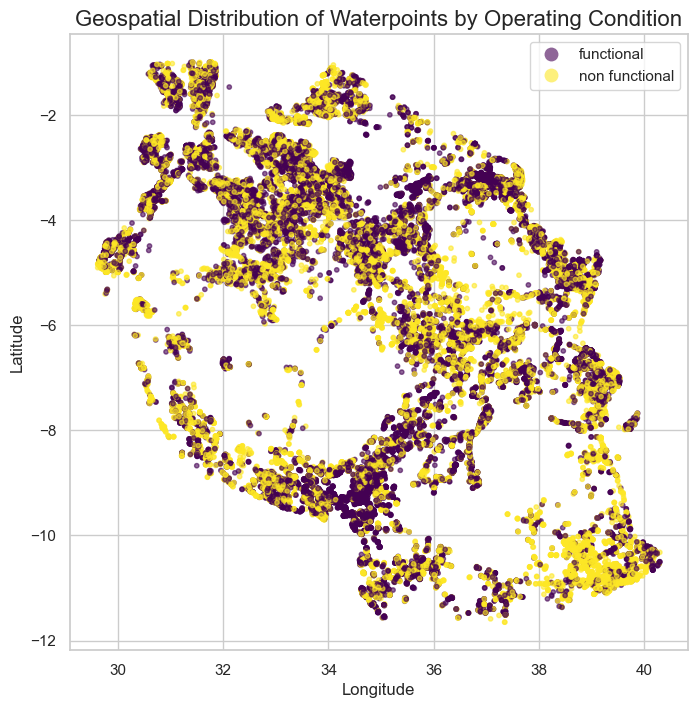

In [23]:
import geopandas as gpd
import seaborn as sns

# Convert the DataFrame to a GeoDataFrame
train_merge_gdf = gpd.GeoDataFrame(
    train_merge, geometry=gpd.points_from_xy(train_merge.longitude, train_merge.latitude)
)

# Plotting
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Plot geospatial points colored by status_group
train_merge_gdf.plot(column='status_group', cmap='viridis', legend=True, markersize=10, alpha=0.6, figsize=(12, 8))

# Customize plot
plt.title('Geospatial Distribution of Waterpoints by Operating Condition', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Show plot
plt.show()

In [20]:
## Define target variable and predictors

In [21]:
#y = train_merge['status_group']
#X = train_merge.drop (columns = 'status_group')

In [23]:
# Modelling

In [24]:
# Evaluation

In [25]:
# Conclusion